# Federated Learning (Server-Clients Collaborative Training)

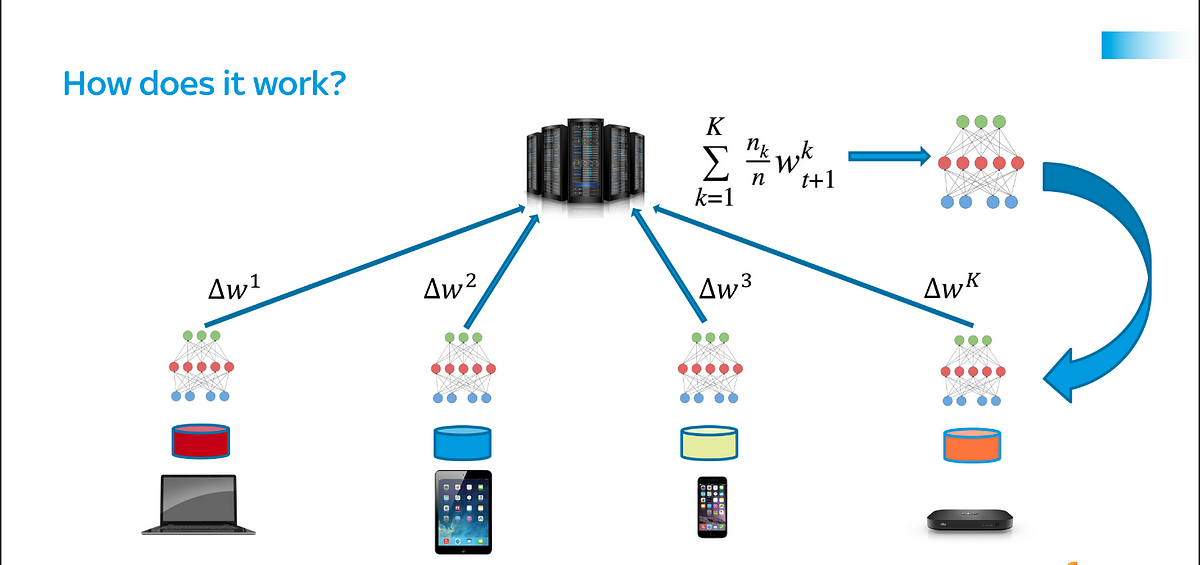

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, valid_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16338941.56it/s]


Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 373009.85it/s]


Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4331919.03it/s]


Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2236240.02it/s]


Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



In [3]:
# @title Hyper-parameter
#--------------------
classes = 10
# input_dim = 784
#  {[num_clients, epochs_per_client]} = {[1, 1], [1, 2], [1, 4], [2, 1], [2, 2], [2, 4], [4, 1], [4, 2], [4, 4]}
num_clients = 4 # Defined there are 4 client devices in network joining for receiving federation-based server-client co-training
rounds = 30 # (global epoch)
batch_size = 128
epochs_per_client = 4 # Defined preparing a few batch run on clients to prepare weight direction (local epoch)
learning_rate = 2e-2
#---------------------

In [4]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_valid_size = len(valid_dataset)
total_train_size, total_valid_size, total_test_size

(49800, 10200, 10000)

In [5]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [6]:
# @title Server Network
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [7]:
# @title Multiple Client Networks
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()



examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

# Server-Client Training (FedAvg in progress)

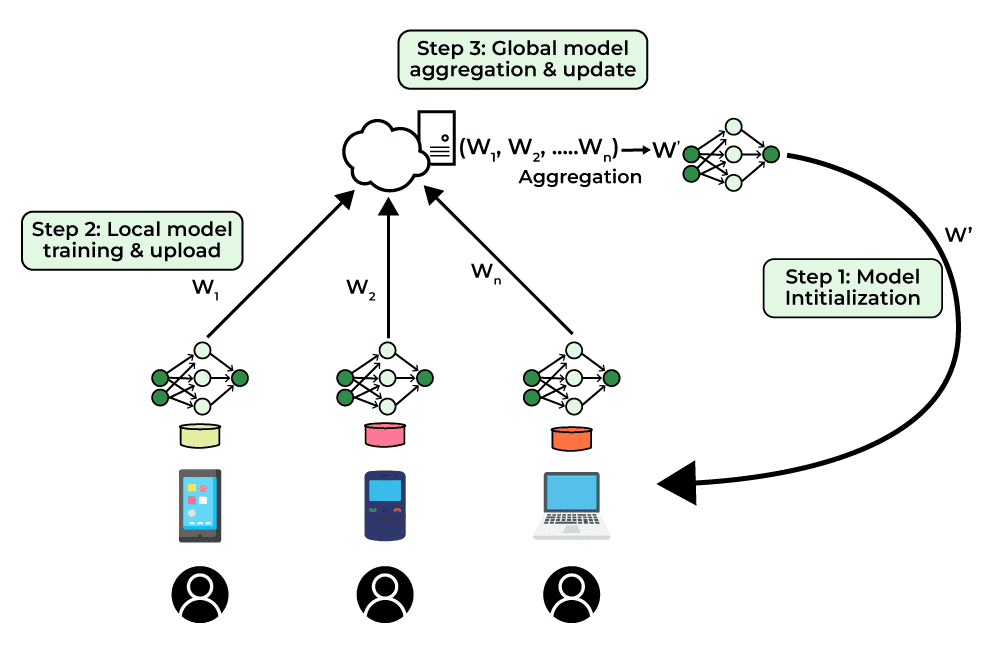

In [8]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    #---Step1: Model init
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    #---Step2: Local model training and upload
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    #---Step3: Global model aggregation and update
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    valid_loss, valid_acc = global_net.evaluate(valid_dataset)
    print('After round {} || train_loss = {}, train_acc = {} || valid_loss = {}, valid_acc = {}\n'.format(i + 1, round(train_loss, 4), round(train_acc, 4),
            round(valid_loss, 4), round(valid_acc, 4)))
    history.append((train_loss, valid_loss))

Start Round 1 ...
client_0: Loss = 0.2772, Accuracy = 0.9197
client_1: Loss = 0.2776, Accuracy = 0.919
client_2: Loss = 0.2678, Accuracy = 0.9223
client_3: Loss = 0.277, Accuracy = 0.9218
After round 1 || train_loss = 0.2585, train_acc = 0.9234 || valid_loss = 0.2613, valid_acc = 0.921

Start Round 2 ...
client_0: Loss = 0.1456, Accuracy = 0.9584
client_1: Loss = 0.1432, Accuracy = 0.9591
client_2: Loss = 0.1415, Accuracy = 0.9608
client_3: Loss = 0.1492, Accuracy = 0.958
After round 2 || train_loss = 0.1351, train_acc = 0.961 || valid_loss = 0.1376, valid_acc = 0.9593

Start Round 3 ...
client_0: Loss = 0.1011, Accuracy = 0.9718
client_1: Loss = 0.0987, Accuracy = 0.9712
client_2: Loss = 0.0988, Accuracy = 0.9723
client_3: Loss = 0.1067, Accuracy = 0.9698
After round 3 || train_loss = 0.0973, train_acc = 0.9721 || valid_loss = 0.0984, valid_acc = 0.9696

Start Round 4 ...
client_0: Loss = 0.0825, Accuracy = 0.9755
client_1: Loss = 0.0786, Accuracy = 0.9779
client_2: Loss = 0.0772, Acc

#### Train-Test Evaluation

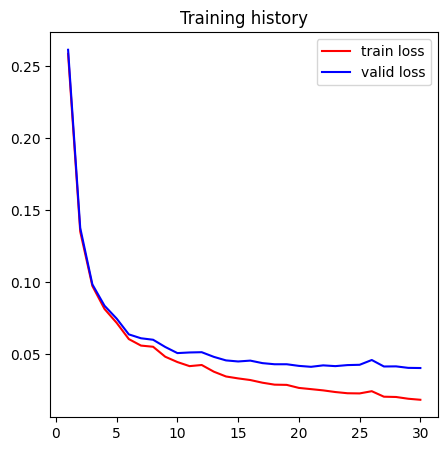

In [9]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='valid loss')
plt.legend()
plt.title('Training history')
plt.show()

-----
# Homework
ปรับการใช้จำนวน clients และจำนวน epochs_per_client เป็นจำนวนใน array ข้างใต้\

- โดยจับเป็นคู่ฝึกฝน เช่น {[num_clients, epochs_per_client]} = {[1, 1], [1, 2], [1, 4], [2, 1], [2, 2], [2, 4], [4, 1], [4, 2], [4, 4]}

```
# @title Hyper-parameter
#--------------------
classes = 10
# input_dim = 784

num_clients = [1, 2, 6] <------ define this
rounds = 30
batch_size = 128
epochs_per_client = [1, 2, 4] <------- define this
learning_rate = 2e-2
#---------------------
```


1. การเรียนที่ clients หลายอุปกรณ์ที่น้อยลงหรือเพิ่มเข้ามาเยอะขึ้น สามารถใช้ FederatedNet (Simple ConvNet) ทำให้เรียนรู้ ช่วยจำ หรือด้อยประสิทธิภาพ มากหรือน้อยอย่างไร
2. เพิ่มหรือลด epoch_per_clients เพื่อเตรียมน้ำหนักจากฝั่ง clients มีผลอย่างไรก่อนเรียนรู้จากส่วนกลาง ทั้งประสิทธิภาพและทรัพยากรอื่น เช่น เวลา

เปรียบเทียบ วิเคราะห์ และอภิปรายผล จัดทำเป็น PDF
